This code is copy pasted and modified from:
https://github.com/YifanJiang233/Deep_BSDE_solver/tree/master.

Do I have to add a MIT license?

Note that the paper 

[1] E, W., Han, J., and Jentzen, A. Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations, Communications in Mathematics and Statistics, 5, 349–380 (2017).

is referenced but no subnetworks are used but a network that also takes in time. 
The actual implementation is for 

https://arxiv.org/pdf/2101.01869.pdf

[2] Jiang,Y., Li, J. Convergence of the deep bsde method for fbsdes with non-lipschitz coefficients.

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class fbsde():
    def __init__(self, x_0, b, sigma, f, g, T, dim_x,dim_y,dim_d, guess_y_0 = [0,1] ):
        self.x_0 = x_0.to(device)
        self.b = b
        self.sigma = sigma
        self.f = f
        self.g = g
        self.T = T
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_d = dim_d
        self.guess_y_0 = guess_y_0 # range


class Model(nn.Module):
    def __init__(self, equation, dim_h):
        super(Model, self).__init__()
        self.equation= equation

        # specifying parameters of NN
        l = torch.rand(equation.dim_y, device=device)
        self.y_0 = nn.Parameter(equation.guess_y_0[0]*l+ equation.guess_y_0[1]*(1-l))
        self.linear1 = nn.Linear(equation.dim_x+1, dim_h) # dim_x + 1  the extra 1 for time
        self.linear2 = nn.Linear(dim_h, dim_h)
        # self.linear3 = nn.Linear(dim_h, dim_h)
        self.linear4 = nn.Linear(dim_h, equation.dim_y*equation.dim_d)
    
    def get_z(self,x,t):
        tmp = torch.cat((x, t*torch.ones(x.size()[0], 1,device=device)), 1)
        tmp = F.relu(self.linear1(tmp))
        tmp = F.relu(self.linear2(tmp))
        # tmp = F.relu(self.linear3(tmp))
        return self.linear4(tmp).reshape(-1, self.equation.dim_y, self.equation.dim_d)
        

    def forward(self,batch_size, N):
        dt = self.equation.T / N
        x = self.equation.x_0+torch.zeros(batch_size,self.equation.dim_x,device=device)
        y = self.y_0+torch.zeros(batch_size,self.equation.dim_y,device=device)

        for i in range(N):
            t = dt*i
            z = self.get_z(x,t)

            dW = torch.randn(batch_size, self.equation.dim_d, 1, device=device) * np.sqrt(dt)
            x = x+self.equation.b(t, x, y)*dt+torch.matmul( self.equation.sigma(t, x), dW).reshape(-1, self.equation.dim_x)
            y = y-self.equation.f(t, x, y, z)*dt + torch.matmul(z, dW).reshape(-1, self.equation.dim_y)
        return x, y

class BSDEsolver():
    def __init__(self, equation, dim_h):
        self.model = Model(equation,dim_h).to(device)
        self.equation = equation

    def train(self, batch_size, N, itr, log):
        criterion = torch.nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(self.model.parameters())
        loss_data, y0_data = [], []

        for i in range(itr):
            x, y = self.model(batch_size,N)
            loss = criterion(self.equation.g(x), y)
            loss_data.append(float(loss))
            y0_data.append(float(self.model.y_0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if log  and i%int(itr/20) == 0:
                print(f"loss: {float(loss):7.2f} y0: {float(self.model.y_0):7.2f} done: {i/itr*100:5.2f}% Iteration: {i}")
        return loss_data, y0_data
            


In [62]:
mu = 0.07
sig = 0.3
r = 0.02
K = 110
dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 1, 1, 1, 7, 10, 1000, 1000
guess_y_0 = [15,17]

x_0, T = 100*torch.ones(dim_x), 1


def b(t, x, y):
    return mu*x.reshape(batch_size, dim_x)


def sigma(t, x):
    return sig*x.reshape(batch_size, dim_x, dim_d)

#f_american doesnt work
def f_american(t, x, y, z):
    return (-r*y + r*K* (y<=g(x))).reshape(batch_size, dim_y)

def f_europian(t, x, y, z):
    return (-r*y ).reshape(batch_size, dim_y)


def g(x):
    return torch.max(K-x, torch.zeros(batch_size, dim_y, device=device)) 


equation = fbsde(x_0, b, sigma, f_europian, g, T,dim_x, dim_y, dim_d, guess_y_0)

bsde_solver = BSDEsolver(equation, dim_h)

loss:  341.71 y0:   16.47 done:  0.00% Iteration: 0
loss:  127.85 y0:   16.43 done:  5.00% Iteration: 50
loss:   92.63 y0:   16.38 done: 10.00% Iteration: 100
loss:   95.92 y0:   16.33 done: 15.00% Iteration: 150
loss:   92.74 y0:   16.28 done: 20.00% Iteration: 200
loss:   90.73 y0:   16.23 done: 25.00% Iteration: 250
loss:   87.21 y0:   16.18 done: 30.00% Iteration: 300
loss:   89.97 y0:   16.14 done: 35.00% Iteration: 350
loss:   93.61 y0:   16.09 done: 40.00% Iteration: 400
loss:   90.62 y0:   16.04 done: 45.00% Iteration: 450
loss:   79.28 y0:   16.00 done: 50.00% Iteration: 500
loss:   90.33 y0:   15.95 done: 55.00% Iteration: 550
loss:   88.44 y0:   15.91 done: 60.00% Iteration: 600
loss:   95.20 y0:   15.86 done: 65.00% Iteration: 650
loss:   89.51 y0:   15.82 done: 70.00% Iteration: 700
loss:   92.30 y0:   15.77 done: 75.00% Iteration: 750
loss:   83.48 y0:   15.73 done: 80.00% Iteration: 800
loss:   93.75 y0:   15.68 done: 85.00% Iteration: 850
loss:   89.11 y0:   15.64 done:

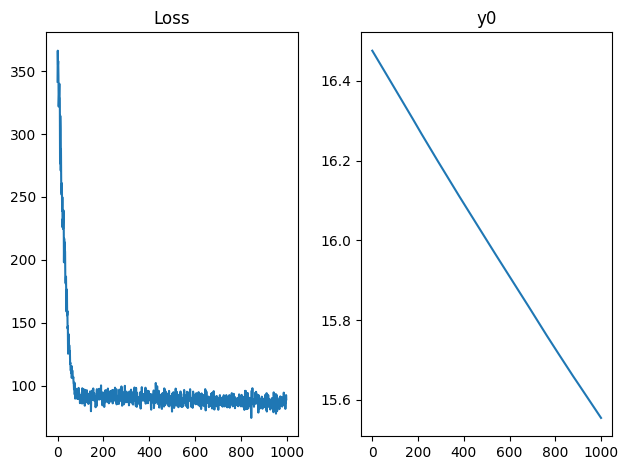

loss:   95.03 y0:   15.55 done:  0.00% Iteration: 0
loss:   94.70 y0:   15.50 done:  5.00% Iteration: 50
loss:   92.23 y0:   15.46 done: 10.00% Iteration: 100
loss:   86.05 y0:   15.41 done: 15.00% Iteration: 150
loss:   88.36 y0:   15.36 done: 20.00% Iteration: 200
loss:   89.15 y0:   15.31 done: 25.00% Iteration: 250
loss:  102.95 y0:   15.27 done: 30.00% Iteration: 300
loss:   90.67 y0:   15.22 done: 35.00% Iteration: 350
loss:   88.97 y0:   15.18 done: 40.00% Iteration: 400
loss:   89.95 y0:   15.13 done: 45.00% Iteration: 450
loss:   87.49 y0:   15.09 done: 50.00% Iteration: 500
loss:   89.77 y0:   15.05 done: 55.00% Iteration: 550
loss:   82.93 y0:   15.01 done: 60.00% Iteration: 600
loss:   81.96 y0:   14.97 done: 65.00% Iteration: 650
loss:   79.24 y0:   14.92 done: 70.00% Iteration: 700
loss:   81.79 y0:   14.88 done: 75.00% Iteration: 750
loss:   85.70 y0:   14.85 done: 80.00% Iteration: 800
loss:   88.90 y0:   14.81 done: 85.00% Iteration: 850
loss:   88.25 y0:   14.77 done:

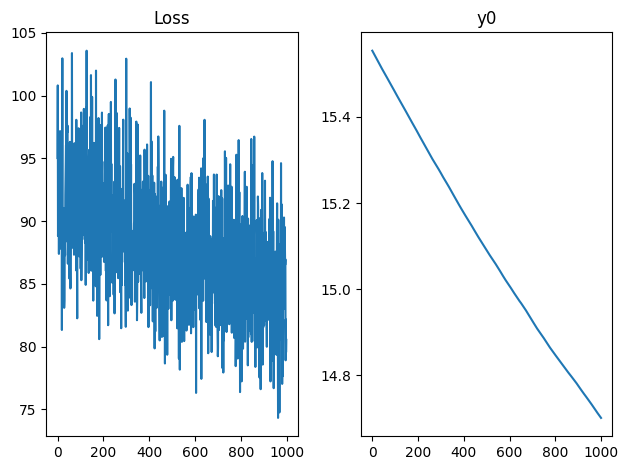

loss:   79.50 y0:   14.70 done:  0.00% Iteration: 0
loss:   74.94 y0:   14.68 done:  5.00% Iteration: 25
loss:   83.50 y0:   14.65 done: 10.00% Iteration: 50
loss:   82.70 y0:   14.63 done: 15.00% Iteration: 75
loss:   78.18 y0:   14.61 done: 20.00% Iteration: 100
loss:   91.63 y0:   14.59 done: 25.00% Iteration: 125
loss:   75.52 y0:   14.57 done: 30.00% Iteration: 150
loss:   85.65 y0:   14.55 done: 35.00% Iteration: 175
loss:   81.08 y0:   14.53 done: 40.00% Iteration: 200
loss:   81.04 y0:   14.51 done: 45.00% Iteration: 225
loss:   77.90 y0:   14.48 done: 50.00% Iteration: 250
loss:   70.60 y0:   14.47 done: 55.00% Iteration: 275
loss:   74.96 y0:   14.45 done: 60.00% Iteration: 300
loss:   74.58 y0:   14.43 done: 65.00% Iteration: 325
loss:   75.09 y0:   14.41 done: 70.00% Iteration: 350
loss:   70.59 y0:   14.39 done: 75.00% Iteration: 375
loss:   74.02 y0:   14.37 done: 80.00% Iteration: 400
loss:   77.85 y0:   14.36 done: 85.00% Iteration: 425
loss:   69.09 y0:   14.34 done: 9

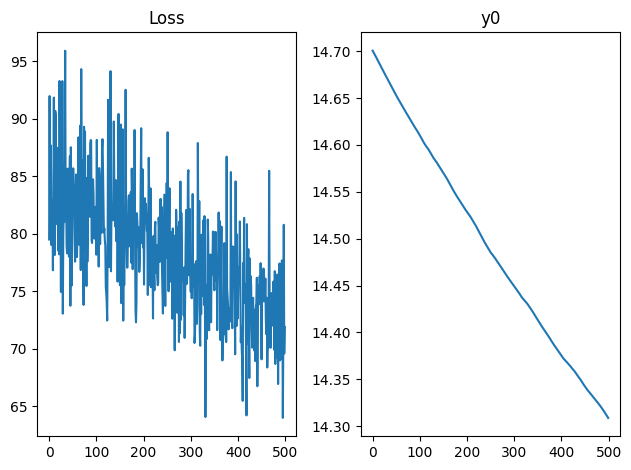

loss:   62.63 y0:   14.31 done:  0.00% Iteration: 0
loss:   66.27 y0:   14.29 done:  5.00% Iteration: 25
loss:   68.60 y0:   14.28 done: 10.00% Iteration: 50
loss:   63.98 y0:   14.26 done: 15.00% Iteration: 75
loss:   61.29 y0:   14.25 done: 20.00% Iteration: 100
loss:   60.79 y0:   14.23 done: 25.00% Iteration: 125
loss:   62.44 y0:   14.22 done: 30.00% Iteration: 150
loss:   67.96 y0:   14.20 done: 35.00% Iteration: 175
loss:   62.05 y0:   14.19 done: 40.00% Iteration: 200
loss:   59.32 y0:   14.18 done: 45.00% Iteration: 225
loss:   60.36 y0:   14.17 done: 50.00% Iteration: 250
loss:   58.59 y0:   14.16 done: 55.00% Iteration: 275
loss:   54.76 y0:   14.15 done: 60.00% Iteration: 300
loss:   59.44 y0:   14.14 done: 65.00% Iteration: 325
loss:   63.12 y0:   14.13 done: 70.00% Iteration: 350
loss:   61.41 y0:   14.13 done: 75.00% Iteration: 375
loss:   53.28 y0:   14.12 done: 80.00% Iteration: 400
loss:   55.77 y0:   14.11 done: 85.00% Iteration: 425
loss:   50.37 y0:   14.11 done: 9

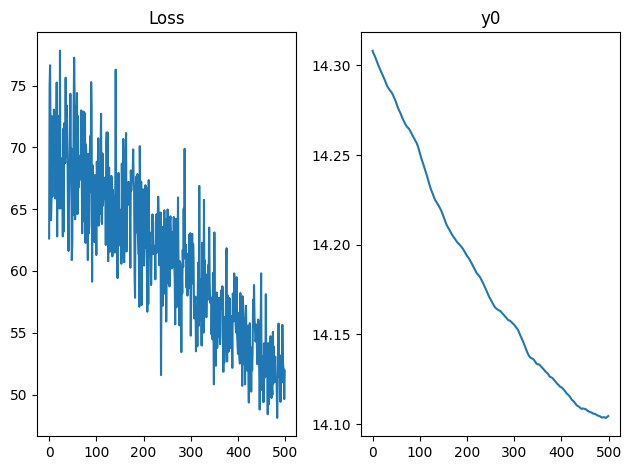

loss:   46.42 y0:   14.11 done:  0.00% Iteration: 0
loss:   49.79 y0:   14.11 done:  5.00% Iteration: 10
loss:   49.20 y0:   14.10 done: 10.00% Iteration: 20
loss:   49.65 y0:   14.10 done: 15.00% Iteration: 30
loss:   50.61 y0:   14.10 done: 20.00% Iteration: 40
loss:   44.93 y0:   14.10 done: 25.00% Iteration: 50
loss:   46.27 y0:   14.10 done: 30.00% Iteration: 60
loss:   43.84 y0:   14.10 done: 35.00% Iteration: 70
loss:   40.44 y0:   14.10 done: 40.00% Iteration: 80
loss:   44.82 y0:   14.09 done: 45.00% Iteration: 90
loss:   42.64 y0:   14.09 done: 50.00% Iteration: 100
loss:   45.52 y0:   14.09 done: 55.00% Iteration: 110
loss:   44.43 y0:   14.09 done: 60.00% Iteration: 120
loss:   40.89 y0:   14.08 done: 65.00% Iteration: 130
loss:   42.73 y0:   14.08 done: 70.00% Iteration: 140
loss:   40.67 y0:   14.08 done: 75.00% Iteration: 150
loss:   39.58 y0:   14.08 done: 80.00% Iteration: 160
loss:   40.72 y0:   14.08 done: 85.00% Iteration: 170
loss:   40.59 y0:   14.08 done: 90.00% 

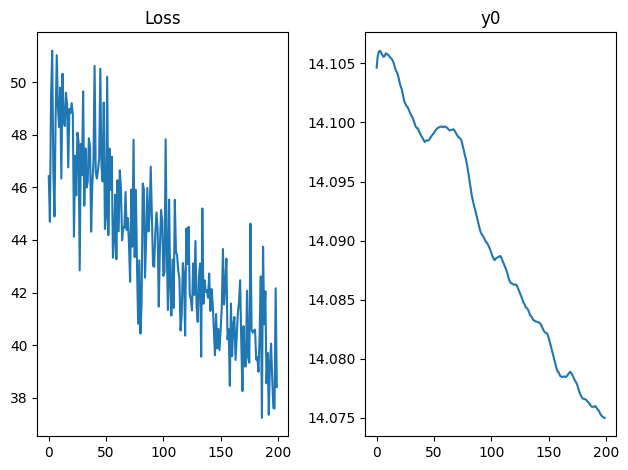

loss:   39.76 y0:   14.08 done:  0.00% Iteration: 0
loss:   36.99 y0:   14.08 done:  5.00% Iteration: 10
loss:   36.88 y0:   14.08 done: 10.00% Iteration: 20
loss:   36.03 y0:   14.08 done: 15.00% Iteration: 30
loss:   34.70 y0:   14.08 done: 20.00% Iteration: 40
loss:   34.68 y0:   14.08 done: 25.00% Iteration: 50
loss:   36.29 y0:   14.08 done: 30.00% Iteration: 60
loss:   35.34 y0:   14.08 done: 35.00% Iteration: 70
loss:   34.77 y0:   14.08 done: 40.00% Iteration: 80
loss:   35.29 y0:   14.08 done: 45.00% Iteration: 90
loss:   34.68 y0:   14.08 done: 50.00% Iteration: 100
loss:   35.53 y0:   14.08 done: 55.00% Iteration: 110
loss:   33.10 y0:   14.09 done: 60.00% Iteration: 120
loss:   32.71 y0:   14.09 done: 65.00% Iteration: 130
loss:   31.20 y0:   14.09 done: 70.00% Iteration: 140
loss:   32.98 y0:   14.08 done: 75.00% Iteration: 150
loss:   31.83 y0:   14.08 done: 80.00% Iteration: 160
loss:   30.92 y0:   14.08 done: 85.00% Iteration: 170
loss:   28.51 y0:   14.08 done: 90.00% 

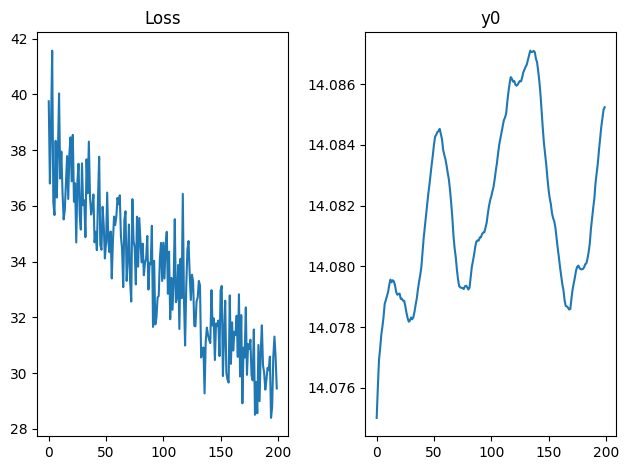

In [63]:
import matplotlib.pyplot as plt

torch.manual_seed(46)
NN = [1,2, 5, 10,20,40]
itrs = [1000,1000,500,500,200,200]
for N,itr in zip(NN,itrs): 
    loss, y0=bsde_solver.train(batch_size, N,itr, log=True)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(loss)
    axs[0].set_title('Loss')

    axs[1].plot(y0)
    axs[1].set_title('y0')

    plt.tight_layout()
    plt.show()

loss:    3.38 y0:    9.88 done:  0.00% Iteration: 0
loss:    3.32 y0:    9.87 done:  5.00% Iteration: 100
loss:    3.05 y0:    9.88 done: 10.00% Iteration: 200
loss:    3.04 y0:    9.87 done: 15.00% Iteration: 300
loss:    3.34 y0:    9.87 done: 20.00% Iteration: 400
loss:    3.35 y0:    9.88 done: 25.00% Iteration: 500
loss:    3.44 y0:    9.87 done: 30.00% Iteration: 600
loss:    3.50 y0:    9.87 done: 35.00% Iteration: 700
loss:    3.10 y0:    9.87 done: 40.00% Iteration: 800
loss:    3.54 y0:    9.88 done: 45.00% Iteration: 900
loss:    3.23 y0:    9.88 done: 50.00% Iteration: 1000
loss:    3.19 y0:    9.87 done: 55.00% Iteration: 1100
loss:    3.53 y0:    9.87 done: 60.00% Iteration: 1200
loss:    3.26 y0:    9.87 done: 65.00% Iteration: 1300
loss:    3.04 y0:    9.88 done: 70.00% Iteration: 1400
loss:    3.46 y0:    9.88 done: 75.00% Iteration: 1500
loss:    3.20 y0:    9.89 done: 80.00% Iteration: 1600
loss:    3.48 y0:    9.89 done: 85.00% Iteration: 1700
loss:    3.42 y0:    9

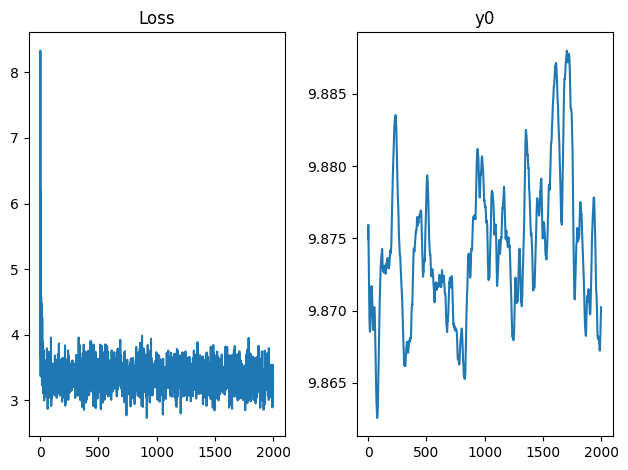

In [72]:
itr = 2000
loss, y0=bsde_solver.train(batch_size, N, itr, log=True)

fig, axs = plt.subplots(1,2)
axs[0].plot(loss)
axs[0].set_title('Loss')

axs[1].plot(y0)
axs[1].set_title('y0')

plt.tight_layout()
plt.show()

# Example multi-dimensional European option
TODO

In [63]:
mu = 0.07
sig = 0.3
r = 0.02
K = 110
dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 1, 1, 1, 11, 20, 5000, 1000
guess_y_0 = [15,15]

x_0, T = 100*torch.ones(dim_x), 1


def b(t, x, y):
    return mu*x.reshape(batch_size, dim_x)


def sigma(t, x):
    return sig*x.reshape(batch_size, dim_x, dim_d)

#f_american doesnt work
def f_american(t, x, y, z):
    return (-r*y + r*K* (y<=g(x))).reshape(batch_size, dim_y)

def f_europian(t, x, y, z):
    return (-r*y ).reshape(batch_size, dim_y)


def g(x):
    return torch.max(K-x, torch.zeros(batch_size, dim_y, device=device)) 


equation = fbsde(x_0, b, sigma, f_europian, g, T,dim_x, dim_y, dim_d, guess_y_0)

bsde_solver = BSDEsolver(equation, dim_h)

In [64]:
import matplotlib.pyplot as plt

torch.manual_seed(46)
NN = [2, 5, 10,20,40]
itrs = [1000,1000,500,200,100]
for N,itr in zip(NN,itrs): 
    loss, y0=bsde_solver.train(batch_size, N,itr, log=True)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(loss)
    axs[0].set_title('Loss')

    axs[1].plot(y0)
    axs[1].set_title('y0')

    plt.tight_layout()
    plt.show()

loss:  273.51 y0:   15.00 done:  0.00% Iteration: 0
loss:  193.44 y0:   14.95 done:  5.00% Iteration: 50
loss:   94.57 y0:   14.91 done: 10.00% Iteration: 100
loss:   94.47 y0:   14.86 done: 15.00% Iteration: 150
loss:   85.41 y0:   14.82 done: 20.00% Iteration: 200
loss:   81.31 y0:   14.78 done: 25.00% Iteration: 250
loss:   93.90 y0:   14.73 done: 30.00% Iteration: 300
loss:   98.53 y0:   14.69 done: 35.00% Iteration: 350
loss:   86.25 y0:   14.65 done: 40.00% Iteration: 400


KeyboardInterrupt: 

# Examples
## Example 1

not fully convinced by the paper <br> 
the theoretical value should be: <br>
Y0 . = 0.39647

loss:    0.64 y0:    0.74 done:  0.00% Iteration: 0
loss:    0.29 y0:    0.69 done:  5.00% Iteration: 50
loss:    0.11 y0:    0.65 done: 10.00% Iteration: 100
loss:    0.06 y0:    0.62 done: 15.00% Iteration: 150
loss:    0.04 y0:    0.60 done: 20.00% Iteration: 200
loss:    0.02 y0:    0.58 done: 25.00% Iteration: 250
loss:    0.01 y0:    0.56 done: 30.00% Iteration: 300
loss:    0.01 y0:    0.54 done: 35.00% Iteration: 350
loss:    0.00 y0:    0.53 done: 40.00% Iteration: 400
loss:    0.00 y0:    0.52 done: 45.00% Iteration: 450
loss:    0.00 y0:    0.52 done: 50.00% Iteration: 500
loss:    0.00 y0:    0.51 done: 55.00% Iteration: 550
loss:    0.00 y0:    0.51 done: 60.00% Iteration: 600
loss:    0.00 y0:    0.50 done: 65.00% Iteration: 650
loss:    0.00 y0:    0.50 done: 70.00% Iteration: 700
loss:    0.00 y0:    0.50 done: 75.00% Iteration: 750
loss:    0.00 y0:    0.50 done: 80.00% Iteration: 800
loss:    0.00 y0:    0.50 done: 85.00% Iteration: 850
loss:    0.00 y0:    0.50 done:

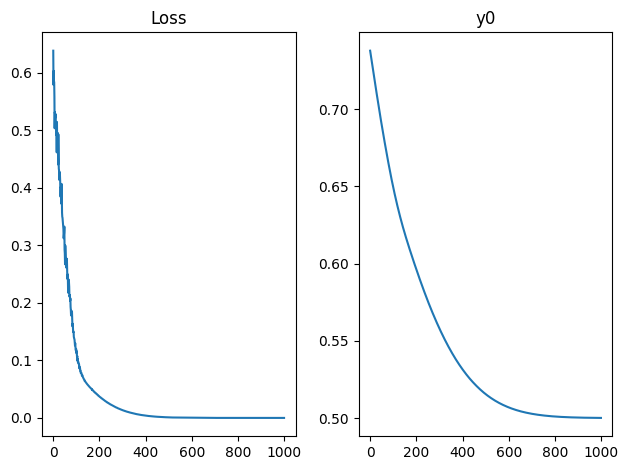

loss:    0.05 y0:    0.50 done:  0.00% Iteration: 0
loss:    0.00 y0:    0.45 done:  5.00% Iteration: 50
loss:    0.00 y0:    0.45 done: 10.00% Iteration: 100
loss:    0.00 y0:    0.45 done: 15.00% Iteration: 150
loss:    0.00 y0:    0.45 done: 20.00% Iteration: 200
loss:    0.00 y0:    0.45 done: 25.00% Iteration: 250
loss:    0.00 y0:    0.45 done: 30.00% Iteration: 300
loss:    0.00 y0:    0.45 done: 35.00% Iteration: 350
loss:    0.00 y0:    0.45 done: 40.00% Iteration: 400
loss:    0.00 y0:    0.45 done: 45.00% Iteration: 450
loss:    0.00 y0:    0.45 done: 50.00% Iteration: 500
loss:    0.00 y0:    0.45 done: 55.00% Iteration: 550
loss:    0.00 y0:    0.45 done: 60.00% Iteration: 600
loss:    0.00 y0:    0.45 done: 65.00% Iteration: 650
loss:    0.00 y0:    0.45 done: 70.00% Iteration: 700
loss:    0.00 y0:    0.45 done: 75.00% Iteration: 750
loss:    0.00 y0:    0.45 done: 80.00% Iteration: 800
loss:    0.00 y0:    0.45 done: 85.00% Iteration: 850
loss:    0.00 y0:    0.45 done:

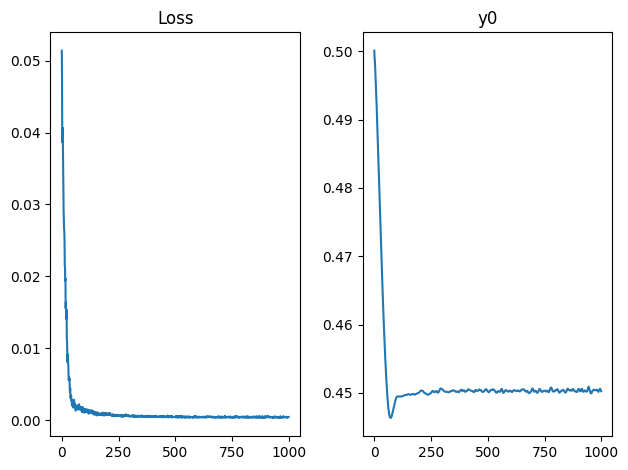

loss:    0.02 y0:    0.45 done:  0.00% Iteration: 0
loss:    0.00 y0:    0.42 done:  5.00% Iteration: 25
loss:    0.00 y0:    0.42 done: 10.00% Iteration: 50
loss:    0.00 y0:    0.42 done: 15.00% Iteration: 75
loss:    0.00 y0:    0.42 done: 20.00% Iteration: 100
loss:    0.00 y0:    0.42 done: 25.00% Iteration: 125
loss:    0.00 y0:    0.42 done: 30.00% Iteration: 150
loss:    0.00 y0:    0.42 done: 35.00% Iteration: 175
loss:    0.00 y0:    0.42 done: 40.00% Iteration: 200
loss:    0.00 y0:    0.42 done: 45.00% Iteration: 225
loss:    0.00 y0:    0.42 done: 50.00% Iteration: 250
loss:    0.00 y0:    0.42 done: 55.00% Iteration: 275
loss:    0.00 y0:    0.42 done: 60.00% Iteration: 300
loss:    0.00 y0:    0.42 done: 65.00% Iteration: 325
loss:    0.00 y0:    0.42 done: 70.00% Iteration: 350
loss:    0.00 y0:    0.42 done: 75.00% Iteration: 375
loss:    0.00 y0:    0.42 done: 80.00% Iteration: 400
loss:    0.00 y0:    0.42 done: 85.00% Iteration: 425
loss:    0.00 y0:    0.42 done: 9

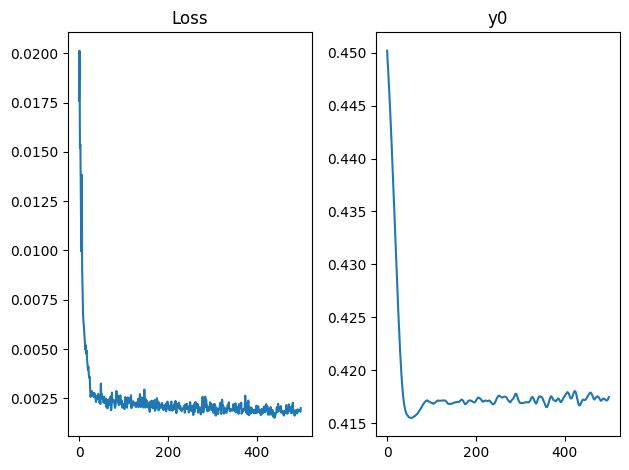

loss:    0.00 y0:    0.42 done:  0.00% Iteration: 0
loss:    0.00 y0:    0.40 done:  5.00% Iteration: 25
loss:    0.00 y0:    0.41 done: 10.00% Iteration: 50
loss:    0.00 y0:    0.41 done: 15.00% Iteration: 75
loss:    0.00 y0:    0.41 done: 20.00% Iteration: 100
loss:    0.00 y0:    0.41 done: 25.00% Iteration: 125
loss:    0.00 y0:    0.41 done: 30.00% Iteration: 150
loss:    0.00 y0:    0.41 done: 35.00% Iteration: 175
loss:    0.00 y0:    0.41 done: 40.00% Iteration: 200
loss:    0.00 y0:    0.41 done: 45.00% Iteration: 225
loss:    0.00 y0:    0.41 done: 50.00% Iteration: 250
loss:    0.00 y0:    0.40 done: 55.00% Iteration: 275
loss:    0.00 y0:    0.41 done: 60.00% Iteration: 300
loss:    0.00 y0:    0.41 done: 65.00% Iteration: 325
loss:    0.00 y0:    0.41 done: 70.00% Iteration: 350
loss:    0.00 y0:    0.41 done: 75.00% Iteration: 375
loss:    0.00 y0:    0.41 done: 80.00% Iteration: 400
loss:    0.00 y0:    0.41 done: 85.00% Iteration: 425
loss:    0.00 y0:    0.41 done: 9

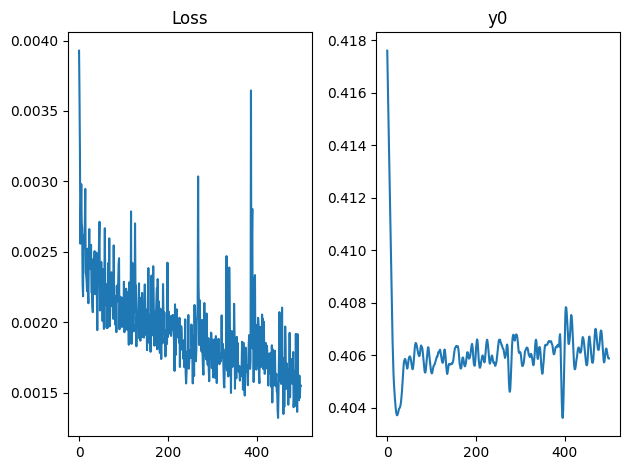

loss:    0.00 y0:    0.40 done:  0.00% Iteration: 0
loss:    0.00 y0:    0.40 done:  5.00% Iteration: 10
loss:    0.00 y0:    0.40 done: 10.00% Iteration: 20
loss:    0.00 y0:    0.40 done: 15.00% Iteration: 30
loss:    0.00 y0:    0.40 done: 20.00% Iteration: 40
loss:    0.00 y0:    0.40 done: 25.00% Iteration: 50
loss:    0.00 y0:    0.40 done: 30.00% Iteration: 60
loss:    0.00 y0:    0.40 done: 35.00% Iteration: 70
loss:    0.00 y0:    0.40 done: 40.00% Iteration: 80
loss:    0.00 y0:    0.40 done: 45.00% Iteration: 90
loss:    0.00 y0:    0.40 done: 50.00% Iteration: 100
loss:    0.00 y0:    0.40 done: 55.00% Iteration: 110
loss:    0.00 y0:    0.40 done: 60.00% Iteration: 120
loss:    0.00 y0:    0.40 done: 65.00% Iteration: 130
loss:    0.00 y0:    0.40 done: 70.00% Iteration: 140
loss:    0.00 y0:    0.40 done: 75.00% Iteration: 150
loss:    0.00 y0:    0.40 done: 80.00% Iteration: 160
loss:    0.00 y0:    0.40 done: 85.00% Iteration: 170
loss:    0.00 y0:    0.40 done: 90.00% 

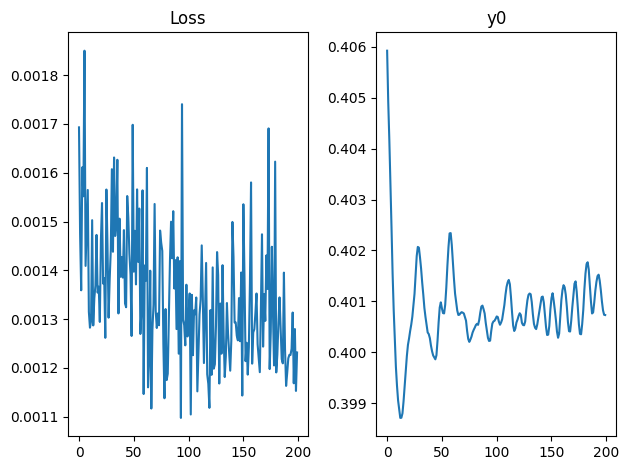

loss:    0.00 y0:    0.40 done:  0.00% Iteration: 0
loss:    0.00 y0:    0.40 done:  5.00% Iteration: 10
loss:    0.00 y0:    0.40 done: 10.00% Iteration: 20
loss:    0.00 y0:    0.40 done: 15.00% Iteration: 30
loss:    0.00 y0:    0.40 done: 20.00% Iteration: 40
loss:    0.00 y0:    0.40 done: 25.00% Iteration: 50
loss:    0.00 y0:    0.40 done: 30.00% Iteration: 60
loss:    0.00 y0:    0.40 done: 35.00% Iteration: 70
loss:    0.00 y0:    0.40 done: 40.00% Iteration: 80
loss:    0.00 y0:    0.40 done: 45.00% Iteration: 90
loss:    0.00 y0:    0.40 done: 50.00% Iteration: 100
loss:    0.00 y0:    0.40 done: 55.00% Iteration: 110
loss:    0.00 y0:    0.40 done: 60.00% Iteration: 120
loss:    0.00 y0:    0.40 done: 65.00% Iteration: 130
loss:    0.00 y0:    0.40 done: 70.00% Iteration: 140
loss:    0.00 y0:    0.40 done: 75.00% Iteration: 150
loss:    0.00 y0:    0.40 done: 80.00% Iteration: 160
loss:    0.00 y0:    0.40 done: 85.00% Iteration: 170
loss:    0.00 y0:    0.40 done: 90.00% 

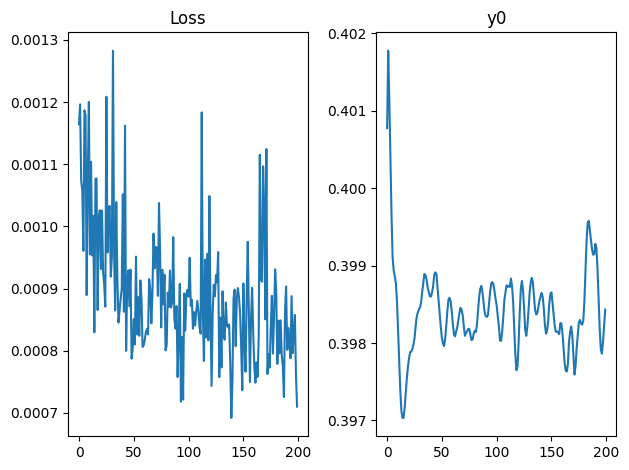

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt

dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 1, 1, 1, 11, 100, 1000, 1000

x_0, T = torch.ones(dim_x), 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def b(t, x, y):
    return (1-x).reshape(batch_size, dim_x)


def sigma(t, x):
    return torch.sqrt(torch.abs(x)).reshape(batch_size, dim_x, dim_d)


def f(t, x, y, z):
    return (-y*x).reshape(batch_size, dim_y)


def g(x):
    return torch.ones(batch_size, dim_y,device=device)


equation = fbsde(x_0, b, sigma, f, g, T,dim_x, dim_y, dim_d)

bsde_solver = BSDEsolver(equation, dim_h)
torch.manual_seed(46)
NN = [1,2, 5, 10,20,40]
itrs = [1000,1000,500,500,200,200]
for N,itr in zip(NN,itrs): 
    loss, y0=bsde_solver.train(batch_size, N,itr, log=True)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(loss)
    axs[0].set_title('Loss')

    axs[1].plot(y0)
    axs[1].set_title('y0')

    plt.tight_layout()
    plt.show()

## Example 2

In [52]:
torch.manual_seed(97)

A = torch.rand(dim_x,device=device)
B = torch.rand(dim_x,device=device)
S = torch.rand(dim_x,device=device)

loss:    0.13 y0:    0.29 done:  0.00% Iteration: 0
loss:    0.06 y0:    0.33 done:  5.00% Iteration: 50
loss:    0.03 y0:    0.37 done: 10.00% Iteration: 100
loss:    0.02 y0:    0.39 done: 15.00% Iteration: 150
loss:    0.01 y0:    0.41 done: 20.00% Iteration: 200
loss:    0.01 y0:    0.42 done: 25.00% Iteration: 250
loss:    0.01 y0:    0.42 done: 30.00% Iteration: 300
loss:    0.01 y0:    0.42 done: 35.00% Iteration: 350
loss:    0.01 y0:    0.42 done: 40.00% Iteration: 400
loss:    0.01 y0:    0.42 done: 45.00% Iteration: 450
loss:    0.01 y0:    0.42 done: 50.00% Iteration: 500
loss:    0.01 y0:    0.42 done: 55.00% Iteration: 550
loss:    0.01 y0:    0.42 done: 60.00% Iteration: 600
loss:    0.01 y0:    0.42 done: 65.00% Iteration: 650
loss:    0.01 y0:    0.42 done: 70.00% Iteration: 700
loss:    0.01 y0:    0.42 done: 75.00% Iteration: 750
loss:    0.01 y0:    0.42 done: 80.00% Iteration: 800
loss:    0.01 y0:    0.42 done: 85.00% Iteration: 850
loss:    0.01 y0:    0.42 done:

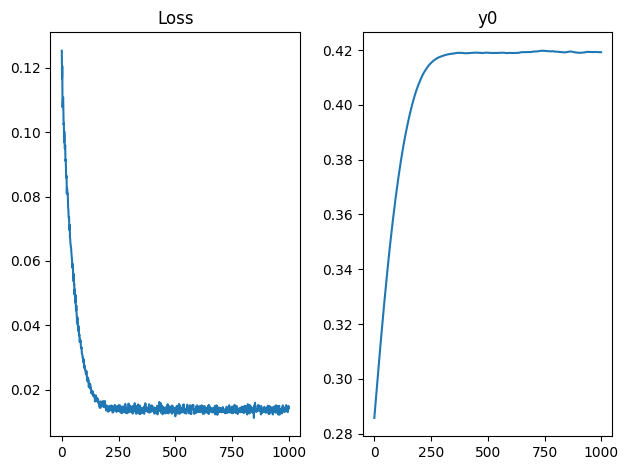

loss:    0.03 y0:    0.42 done:  0.00% Iteration: 0
loss:    0.01 y0:    0.38 done:  5.00% Iteration: 50
loss:    0.01 y0:    0.37 done: 10.00% Iteration: 100
loss:    0.01 y0:    0.37 done: 15.00% Iteration: 150
loss:    0.01 y0:    0.37 done: 20.00% Iteration: 200
loss:    0.01 y0:    0.37 done: 25.00% Iteration: 250
loss:    0.01 y0:    0.37 done: 30.00% Iteration: 300
loss:    0.01 y0:    0.37 done: 35.00% Iteration: 350
loss:    0.01 y0:    0.37 done: 40.00% Iteration: 400
loss:    0.01 y0:    0.37 done: 45.00% Iteration: 450
loss:    0.01 y0:    0.37 done: 50.00% Iteration: 500
loss:    0.01 y0:    0.37 done: 55.00% Iteration: 550
loss:    0.01 y0:    0.37 done: 60.00% Iteration: 600
loss:    0.01 y0:    0.37 done: 65.00% Iteration: 650
loss:    0.01 y0:    0.37 done: 70.00% Iteration: 700
loss:    0.01 y0:    0.37 done: 75.00% Iteration: 750
loss:    0.01 y0:    0.37 done: 80.00% Iteration: 800
loss:    0.01 y0:    0.37 done: 85.00% Iteration: 850
loss:    0.01 y0:    0.37 done:

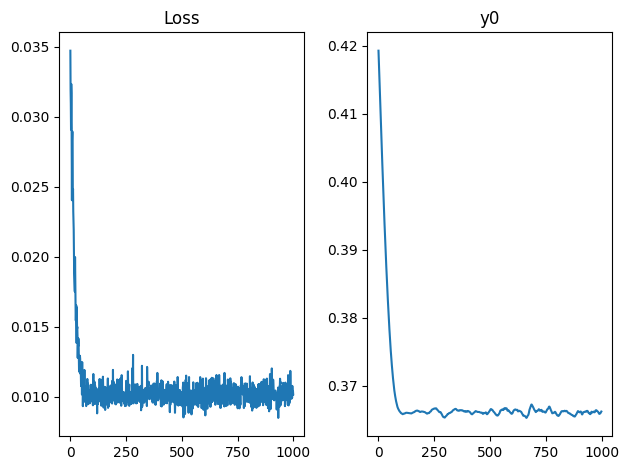

loss:    0.02 y0:    0.37 done:  0.00% Iteration: 0
loss:    0.01 y0:    0.33 done:  5.00% Iteration: 50
loss:    0.00 y0:    0.33 done: 10.00% Iteration: 100
loss:    0.00 y0:    0.33 done: 15.00% Iteration: 150
loss:    0.01 y0:    0.33 done: 20.00% Iteration: 200
loss:    0.00 y0:    0.33 done: 25.00% Iteration: 250
loss:    0.00 y0:    0.33 done: 30.00% Iteration: 300
loss:    0.00 y0:    0.33 done: 35.00% Iteration: 350
loss:    0.00 y0:    0.33 done: 40.00% Iteration: 400
loss:    0.00 y0:    0.33 done: 45.00% Iteration: 450
loss:    0.00 y0:    0.33 done: 50.00% Iteration: 500
loss:    0.00 y0:    0.33 done: 55.00% Iteration: 550
loss:    0.00 y0:    0.33 done: 60.00% Iteration: 600
loss:    0.00 y0:    0.33 done: 65.00% Iteration: 650
loss:    0.00 y0:    0.33 done: 70.00% Iteration: 700
loss:    0.00 y0:    0.33 done: 75.00% Iteration: 750
loss:    0.00 y0:    0.33 done: 80.00% Iteration: 800
loss:    0.00 y0:    0.33 done: 85.00% Iteration: 850
loss:    0.00 y0:    0.33 done:

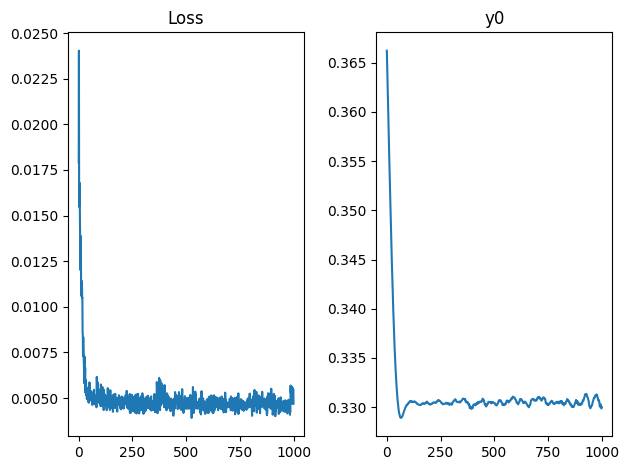

loss:    0.01 y0:    0.33 done:  0.00% Iteration: 0
loss:    0.00 y0:    0.32 done:  5.00% Iteration: 50
loss:    0.00 y0:    0.32 done: 10.00% Iteration: 100
loss:    0.01 y0:    0.32 done: 15.00% Iteration: 150
loss:    0.00 y0:    0.32 done: 20.00% Iteration: 200
loss:    0.00 y0:    0.32 done: 25.00% Iteration: 250
loss:    0.00 y0:    0.32 done: 30.00% Iteration: 300
loss:    0.00 y0:    0.32 done: 35.00% Iteration: 350
loss:    0.00 y0:    0.32 done: 40.00% Iteration: 400
loss:    0.00 y0:    0.32 done: 45.00% Iteration: 450
loss:    0.00 y0:    0.32 done: 50.00% Iteration: 500
loss:    0.00 y0:    0.32 done: 55.00% Iteration: 550
loss:    0.00 y0:    0.32 done: 60.00% Iteration: 600
loss:    0.00 y0:    0.32 done: 65.00% Iteration: 650
loss:    0.00 y0:    0.32 done: 70.00% Iteration: 700
loss:    0.00 y0:    0.32 done: 75.00% Iteration: 750
loss:    0.00 y0:    0.32 done: 80.00% Iteration: 800
loss:    0.00 y0:    0.32 done: 85.00% Iteration: 850
loss:    0.00 y0:    0.32 done:

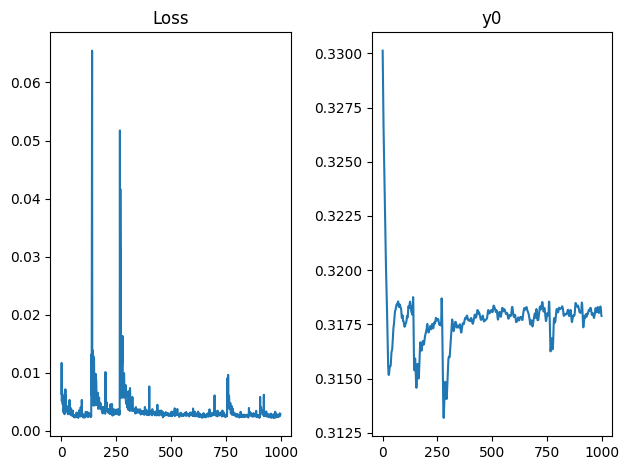

loss:    0.00 y0:    0.32 done:  0.00% Iteration: 0
loss:    0.00 y0:    0.31 done:  5.00% Iteration: 10
loss:    0.00 y0:    0.31 done: 10.00% Iteration: 20
loss:    0.00 y0:    0.31 done: 15.00% Iteration: 30
loss:    0.00 y0:    0.31 done: 20.00% Iteration: 40
loss:    0.00 y0:    0.31 done: 25.00% Iteration: 50
loss:    0.00 y0:    0.31 done: 30.00% Iteration: 60
loss:    0.00 y0:    0.31 done: 35.00% Iteration: 70
loss:    0.00 y0:    0.31 done: 40.00% Iteration: 80
loss:    0.00 y0:    0.31 done: 45.00% Iteration: 90
loss:    0.00 y0:    0.31 done: 50.00% Iteration: 100
loss:    0.00 y0:    0.31 done: 55.00% Iteration: 110
loss:    0.00 y0:    0.31 done: 60.00% Iteration: 120
loss:    0.00 y0:    0.31 done: 65.00% Iteration: 130
loss:    0.00 y0:    0.31 done: 70.00% Iteration: 140
loss:    0.00 y0:    0.31 done: 75.00% Iteration: 150
loss:    0.00 y0:    0.31 done: 80.00% Iteration: 160
loss:    0.00 y0:    0.31 done: 85.00% Iteration: 170
loss:    0.00 y0:    0.31 done: 90.00% 

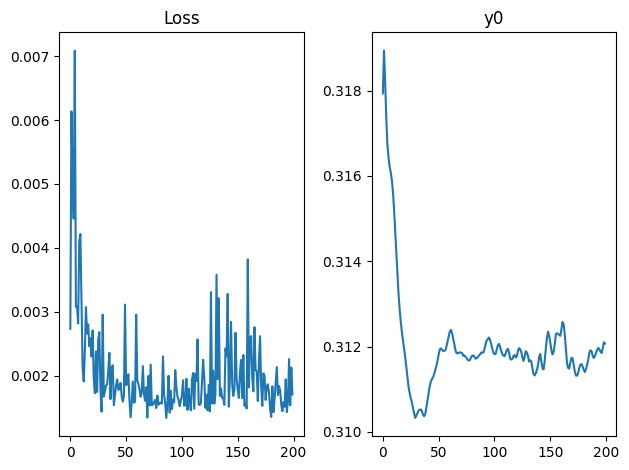

loss:    0.00 y0:    0.31 done:  0.00% Iteration: 0
loss:    0.00 y0:    0.31 done:  5.00% Iteration: 5
loss:    0.00 y0:    0.31 done: 10.00% Iteration: 10
loss:    0.00 y0:    0.31 done: 15.00% Iteration: 15
loss:    0.00 y0:    0.31 done: 20.00% Iteration: 20
loss:    0.00 y0:    0.31 done: 25.00% Iteration: 25
loss:    0.00 y0:    0.31 done: 30.00% Iteration: 30
loss:    0.00 y0:    0.31 done: 35.00% Iteration: 35
loss:    0.00 y0:    0.31 done: 40.00% Iteration: 40
loss:    0.00 y0:    0.31 done: 45.00% Iteration: 45
loss:    0.00 y0:    0.31 done: 50.00% Iteration: 50
loss:    0.00 y0:    0.31 done: 55.00% Iteration: 55
loss:    0.00 y0:    0.31 done: 60.00% Iteration: 60
loss:    0.00 y0:    0.31 done: 65.00% Iteration: 65
loss:    0.00 y0:    0.31 done: 70.00% Iteration: 70
loss:    0.00 y0:    0.31 done: 75.00% Iteration: 75
loss:    0.00 y0:    0.31 done: 80.00% Iteration: 80
loss:    0.00 y0:    0.31 done: 85.00% Iteration: 85
loss:    0.00 y0:    0.31 done: 90.00% Iteration

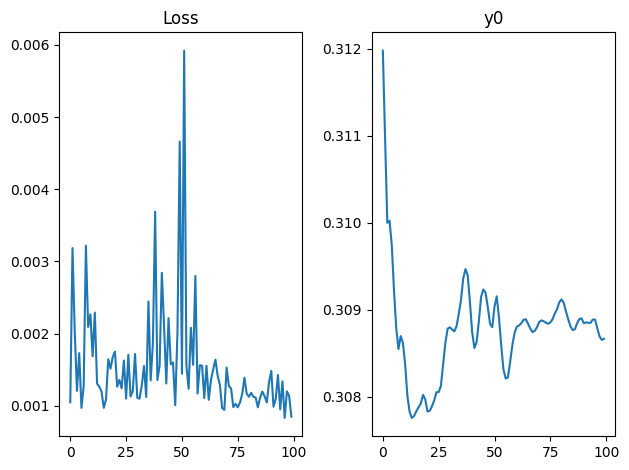

In [53]:
dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 100, 1, 1, 110, 100, 1000, 1000

x_0, T = torch.ones(dim_x), 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def b(t, x, y):
    return (A*(B-x)).reshape(batch_size, dim_x)


def sigma(t, x):
    return (S*torch.sqrt(torch.abs(x))).reshape(batch_size, dim_x, dim_d)


def f(t, x, y, z):
    return -y*torch.max(x, 1)[0].reshape(batch_size, dim_y)


def g(x):
    return torch.ones(batch_size, dim_y,device=device)


equation = fbsde(x_0, b, sigma, f, g, T,dim_x,dim_y,dim_d)

bsde_solver = BSDEsolver(equation, dim_h)

torch.manual_seed(46)
NN = [1,2, 5, 10,20,40,100]
itrs = [1000,1000,1000,1000,200,100]
for N,itr in zip(NN,itrs): 
    loss, y0=bsde_solver.train(batch_size, N,itr, log=True)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(loss)
    axs[0].set_title('Loss')

    axs[1].plot(y0)
    axs[1].set_title('y0')

    plt.tight_layout()
    plt.show()
